In [168]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import matplotlib.dates as mdates
from scipy import signal
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Predicting South Manhattan


## data preparation and loading

In [169]:
# loading april data
df_april_south_manhattan_week = pd.read_csv(r"C:\Users\Max_G\OneDrive\IUBH\5_Semester\Model_Engeneering\Public_Transport_Forecasting\data\interim\Clustered Data\df_4_month_4_weekday.csv", index_col=[0])
df_april_south_manhattan_week.Date = pd.to_datetime(df_april_south_manhattan_week['Date'])
df_april_south_manhattan_week.index = pd.to_datetime(df_april_south_manhattan_week.index)

# loading may data
df_may_south_manhattan_week = pd.read_csv(r"C:\Users\Max_G\OneDrive\IUBH\5_Semester\Model_Engeneering\Public_Transport_Forecasting\data\interim\Clustered Data\df_4_month_5_weekday.csv", index_col=[0])
df_may_south_manhattan_week.Date = pd.to_datetime(df_may_south_manhattan_week['Date'])
df_may_south_manhattan_week.index = pd.to_datetime(df_may_south_manhattan_week.index)


In [170]:
# for training
endog_april = df_april_south_manhattan_week.reset_index()
endog_april = endog_april.drop(columns=['index', 'Hour', 'Weekday', 'Date'])

# for testing
endog_may = df_may_south_manhattan_week.reset_index()
endog_may = endog_may .drop(columns=['index', 'Hour', 'Weekday', 'Date'])

## Creating a SARIMA Model

                                      SARIMAX Results                                       
Dep. Variable:                                Count   No. Observations:                  528
Model:             SARIMAX(0, 1, 6)x(1, 1, [1], 24)   Log Likelihood               -2957.634
Date:                              Tue, 19 Sep 2023   AIC                           5933.267
Time:                                      10:49:08   BIC                           5971.252
Sample:                                           0   HQIC                          5948.169
                                              - 528                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0373      0.028     -1.308      0.191      -0.093       0.019
ma.L2         -0.33

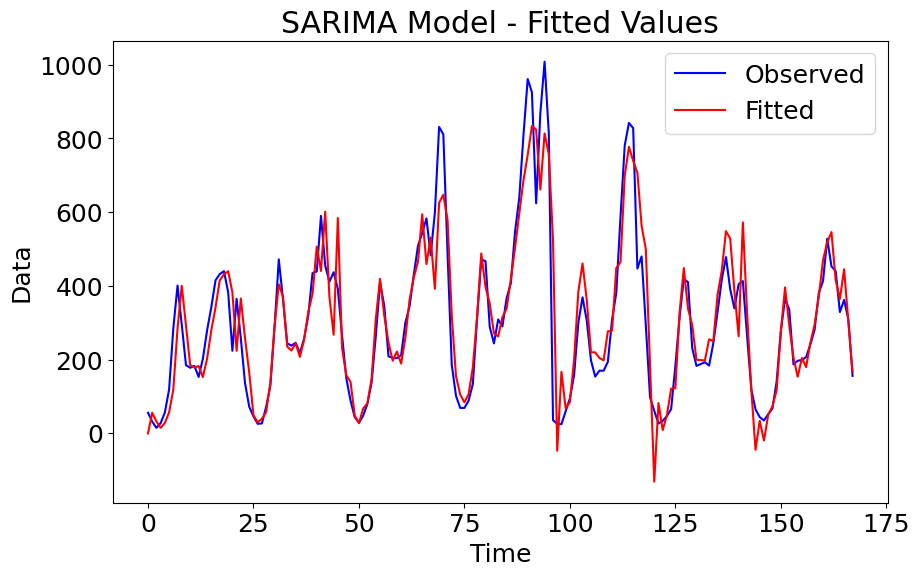

In [171]:
order = (0, 1, 6) 
seasonal_order=(1, 1, 1, 24)

time = np.arange(len(endog_april))

# Fit the SARIMA model with harmonic regression (exogenous variables)
model_0 = SARIMAX(endog_april, order=order, seasonal_order=seasonal_order)
results_0 = model_0.fit()

# Print the model summary
print(results_0.summary())

# Plot the observed data and the fitted values
plt.figure(figsize=(10, 6))
plt.plot(time[0:168], endog_april['Count'][0:168], label='Observed', color='blue')
plt.plot(time[0:168], results_0.fittedvalues[0:168], label='Fitted', color='red')
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('SARIMA Model - Fitted Values')
plt.legend()
plt.show()



# Assuming you have the 'results_0' variable defined
new_row_data = {
    'location': 'South_Manhattan',
    'type': 'Sarima',
    'AIC': results_0.aic
}

# Create a DataFrame with a single row
df_aic = pd.DataFrame([new_row_data])


c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


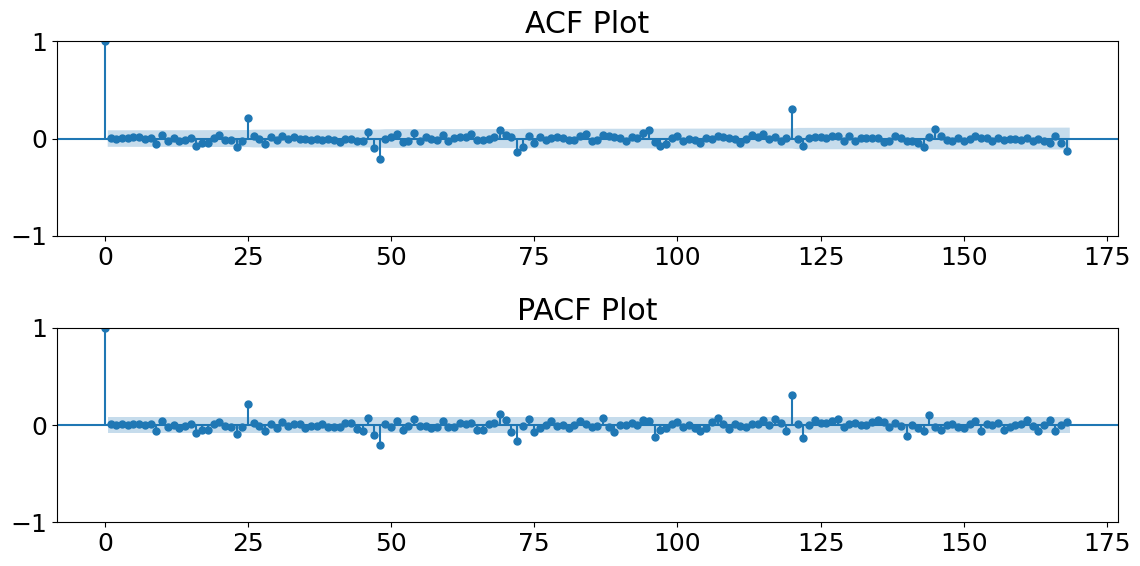

In [172]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(results_0.resid, lags=168   , ax=plt.gca(), title='ACF Plot')
plt.subplot(2, 1, 2)
plot_pacf(results_0.resid, lags=168, ax=plt.gca(), title='PACF Plot')
plt.tight_layout()
plt.show()

## Sarimax

### Harmonic Regression Preparation

In [173]:
def getMaxPeriodogram(freq, Pxx_spec, num_top):
    # Find the indices of the top 'num_top' maximum PSDs
    top_indices = np.argsort(Pxx_spec)[-num_top:][::-1]
    
    # Extract the frequencies and PSDs for the top 'num_top' maximum PSDs
    freqMax = freq[top_indices]
    maxPsd = Pxx_spec[top_indices]
    
    # Convert to periods
    periodMax = 1 / freqMax
    
    return maxPsd, freqMax, periodMax

In [174]:
# %% generate periodogram
freq, Pxx_spec = signal.periodogram( \
   df_april_south_manhattan_week['Count'].values, scaling='spectrum')

In [175]:
maxPsd, freqMax_week, periodMax = getMaxPeriodogram(freq ,Pxx_spec, 5)

In [176]:
1/freqMax_week

array([ 24.        ,  12.        , 105.6       ,   8.        ,
        31.05882353])

In [177]:
# %% set font size for plots
plt.rcParams.update({'font.size': 18})

forecast_steps = 48

# (1 day = 24 hours, 1 week = 168 hours)
period01, period02, period03, period04, period05= list(1/freqMax_week)

# extract the number hourly samples
T=len(df_april_south_manhattan_week)
T_predict = T+forecast_steps
time=np.arange(1,T_predict+1)

# create regressors 
omega01=2*np.pi/period01
s1=np.cos(omega01*time)
c1=np.sin(omega01*time)

# create regressors 
omega02=2*np.pi/period02
s2=np.cos(omega02*time)
c2=np.sin(omega02*time)

# create regressors 
omega03=2*np.pi/period03
s3=np.cos(omega03*time)
c3=np.sin(omega03*time)

# create regressors 
omega04=2*np.pi/period04
s4=np.cos(omega04*time)
c4=np.sin(omega04*time)

# create regressors 
omega05=2*np.pi/period05
s5=np.cos(omega05*time)
c5=np.sin(omega05*time)



# %% stack regressors and add intercept
regressors = np.column_stack((s1,c1,s2,c2,s3,c3,s4,c4,s5,c5))
regressors_one = sm.add_constant(regressors)

exog_var = regressors[:528]

# %% create and fit the regression model
model = sm.OLS(df_april_south_manhattan_week['Count'], regressors_one[:528])
results_harmonic = model.fit()

In [178]:
results_harmonic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     112.5
Date:                Tue, 19 Sep 2023   Prob (F-statistic):          8.49e-123
Time:                        10:49:09   Log-Likelihood:                -3316.5
No. Observations:                 528   AIC:                             6655.
Df Residuals:                     517   BIC:                             6702.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        318.8769      5.688     56.066      0.000     307.703     330.050
x1             8.2268      8.043      1.023      0.307      -7.575      24.028
x2          -198.4009      8.043    -24.666      0.000    -214.203    -182.599
x3           -59.6254      8.043     -7.413      0.000     -75.427     -43.824
x4          -138.0598      8.043    -17.164      0.000    -153.861    -122.258
x5            55.3225      8.043      6.878      0.000      39.521      71.124
x6           -41.4764      8.043     -5.157      0.000     -57.278     -25.675
x7            54.3920      8.043      6.762      0.000      38.590      70.194
x8           -18.6963      8.043     -2.324      0.020     -34.498      -2.895
x9            39.3099      8.043      4.887      0.000      23.508      55.112
x10          -32.7224      8.043     -4.068      0.000     -48.524     -16.921
==============================================================================
Omnibus:                      261.840   Durbin-Watson:                   0.575
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2424.630
Skew:                           1.960   Prob(JB):                         0.00
Kurtosis:                      12.739   Cond. No.                         1.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


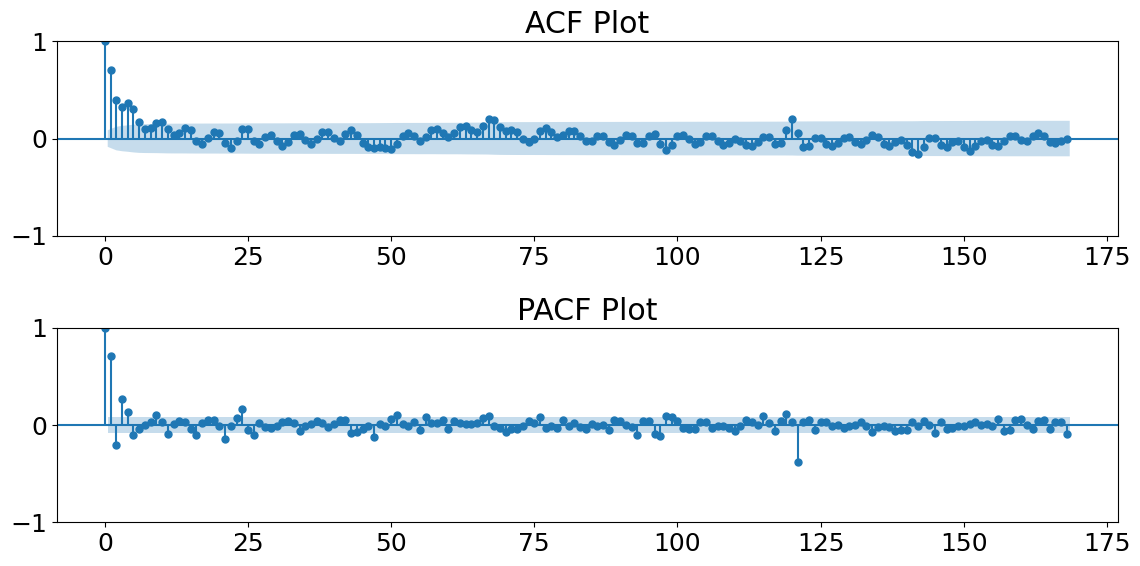

In [179]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(results_harmonic.resid, lags=168   , ax=plt.gca(), title='ACF Plot')
plt.subplot(2, 1, 2)
plot_pacf(results_harmonic.resid, lags=168, ax=plt.gca(), title='PACF Plot')
plt.tight_layout()
plt.show()

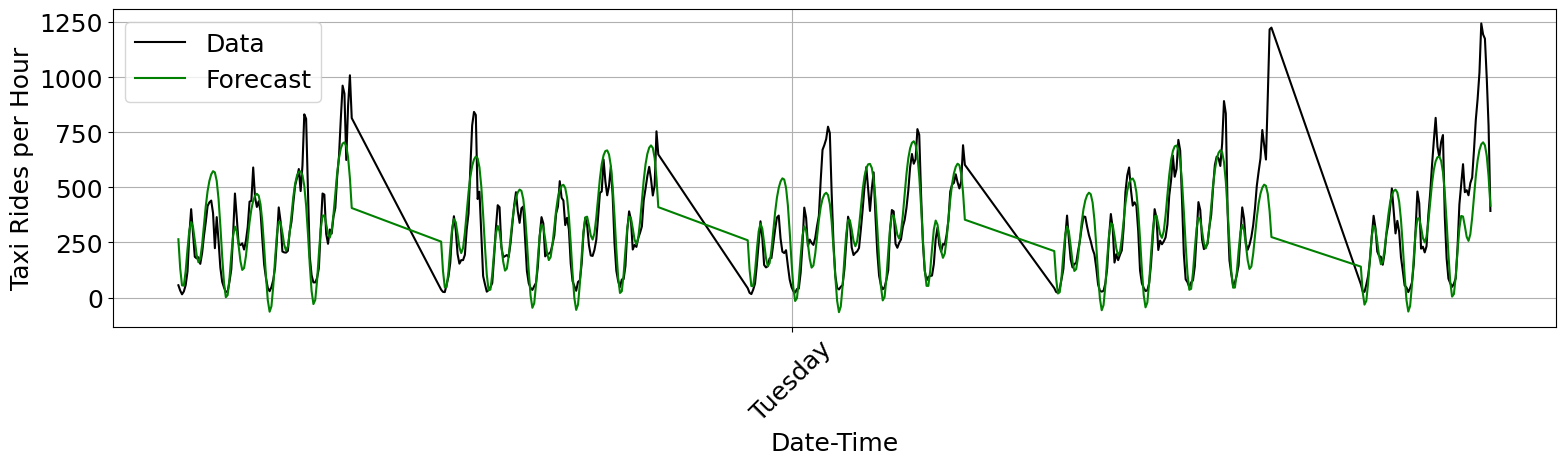

In [180]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot(df_april_south_manhattan_week.index, df_april_south_manhattan_week['Count'], color='k', label='Data')

# Fitted values
plt.plot(df_april_south_manhattan_week.index, results_harmonic.fittedvalues, color='green', label='Forecast')

# Add labels, ticks, and legend
plt.gca().set(xlabel='Date-Time', ylabel='Taxi Rides per Hour')

# Set ticks every 24 hours
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=24))

# Set tick format to display the weekday name
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%A'))

plt.xticks(rotation=45)  # Rotate the tick labels for better readability

plt.legend()
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

### Combining Harmonic Regression with ARMA

In [181]:
arma_model = sm.tsa.ARIMA(results_harmonic.resid, order=(24, 0, 0))
arma_result = arma_model.fit()

c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


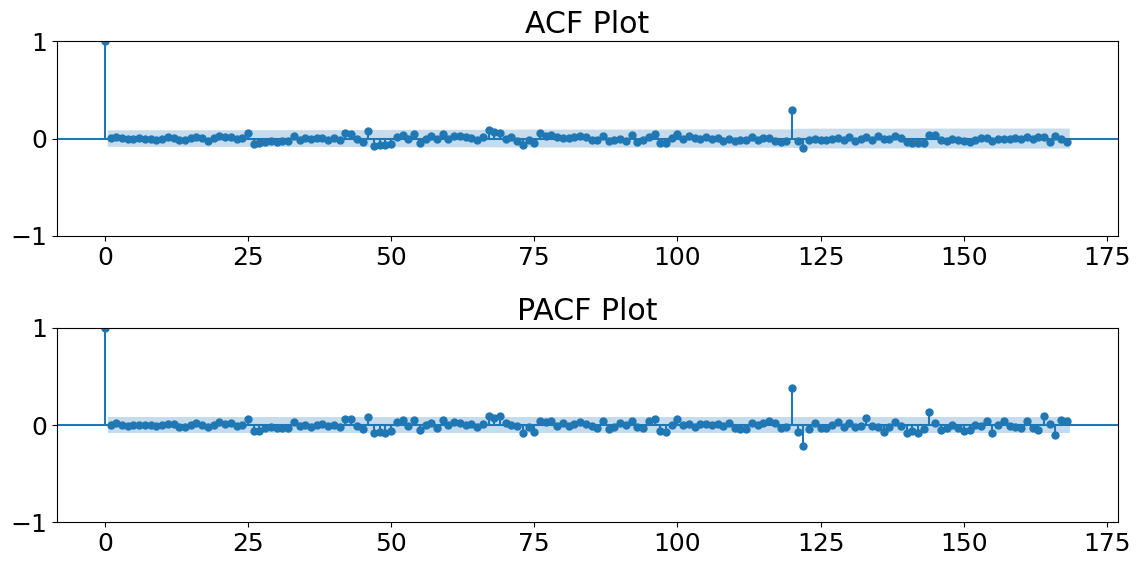

In [182]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(arma_result.resid, lags=168   , ax=plt.gca(), title='ACF Plot')
plt.subplot(2, 1, 2)
plot_pacf(arma_result.resid, lags=168, ax=plt.gca(), title='PACF Plot')
plt.tight_layout()
plt.show()

### putting it all together SARIMAX

In [183]:
order = (24, 0, 0)
seasonal_order = (0, 0, 0, 0)
model = SARIMAX(endog=endog_april['Count'], exog=exog_var, \
    trend='c', order=order, \
    seasonal_order=seasonal_order, \
    enforce_stationarity=True, \
    enforce_invertibility=True)
m_sarimax_24_0 = model.fit()


new_row_data = {
    'location': 'South_Manhattan',
    'type': 'Sarimax',
    'AIC': m_sarimax_24_0.aic
}

# Create a DataFrame with a single row
df_aic = df_aic.append(new_row_data, ignore_index=True)

C:\Users\Max_G\AppData\Local\Temp\ipykernel_22092\288929649.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aic = df_aic.append(new_row_data, ignore_index=True)


In [184]:
m_sarimax_24_0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Count   No. Observations:                  528
Model:              SARIMAX(24, 0, 0)   Log Likelihood               -3067.701
Date:                Tue, 19 Sep 2023   AIC                           6207.401
Time:                        10:49:25   BIC                           6361.089
Sample:                             0   HQIC                          6267.567
                                - 528                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     67.0416     27.468      2.441      0.015      13.205     120.878
x1             8.2477     19.807      0.416      0.677     -30.573      47.068
x2          -198.3055     24.263     -8.173      0.000    -245.860    -150.751
x3           -59.6228     16.651     -3.581      0.000     -92.258     -26.988
x4          -138.0456     15.759     -8.760      0.000    -168.932    -107.159
x5            55.2708     24.309      2.274      0.023       7.626     102.915
x6           -41.4047     28.684     -1.443      0.149     -97.624      14.814
x7            54.4327      9.205      5.913      0.000      36.391      72.475
x8           -18.6963      9.325     -2.005      0.045     -36.973      -0.419
x9            39.2826     25.550      1.537      0.124     -10.794      89.360
x10          -32.7146     25.814     -1.267      0.205     -83.309      17.880
ar.L1          0.8716      0.028     30.660      0.000       0.816       0.927
ar.L2         -0.3007      0.044     -6.817      0.000      -0.387      -0.214
ar.L3          0.1116      0.058      1.941      0.052      -0.001       0.224
ar.L4          0.1820      0.069      2.637      0.008       0.047       0.317
ar.L5         -0.1202      0.086     -1.390      0.164      -0.290       0.049
ar.L6         -0.0360      0.111     -0.323      0.747      -0.254       0.182
ar.L7          0.0368      0.111      0.332      0.740      -0.181       0.254
ar.L8         -0.0185      0.101     -0.183      0.855      -0.216       0.179
ar.L9          0.0191      0.087      0.219      0.826      -0.152       0.190
ar.L10         0.0875      0.089      0.982      0.326      -0.087       0.262
ar.L11        -0.0870      0.090     -0.968      0.333      -0.263       0.089
ar.L12         0.0214      0.102      0.209      0.834      -0.179       0.222
ar.L13         0.0156      0.092      0.169      0.866      -0.165       0.197
ar.L14         0.0008      0.110      0.007      0.994      -0.214       0.216
ar.L15         0.0367      0.100      0.367      0.714      -0.159       0.233
ar.L16        -0.1189      0.092     -1.297      0.195      -0.299       0.061
ar.L17         0.0148      0.083      0.178      0.859      -0.148       0.178
ar.L18         0.0357      0.072      0.496      0.620      -0.106       0.177
ar.L19         0.0170      0.056      0.301      0.763      -0.093       0.127
ar.L20         0.0630      0.057      1.112      0.266      -0.048       0.174
ar.L21        -0.1120      0.052     -2.154      0.031      -0.214      -0.010
ar.L22        -0.0247      0.054     -0.456      0.649      -0.131       0.081
ar.L23        -0.0669      0.045     -1.480      0.139      -0.155       0.022
ar.L24         0.1612      0.037      4.310      0.000       0.088       0.234
sigma2      6474.1154    275.729     23.480      0.000    5933.697    7014.534
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              

c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


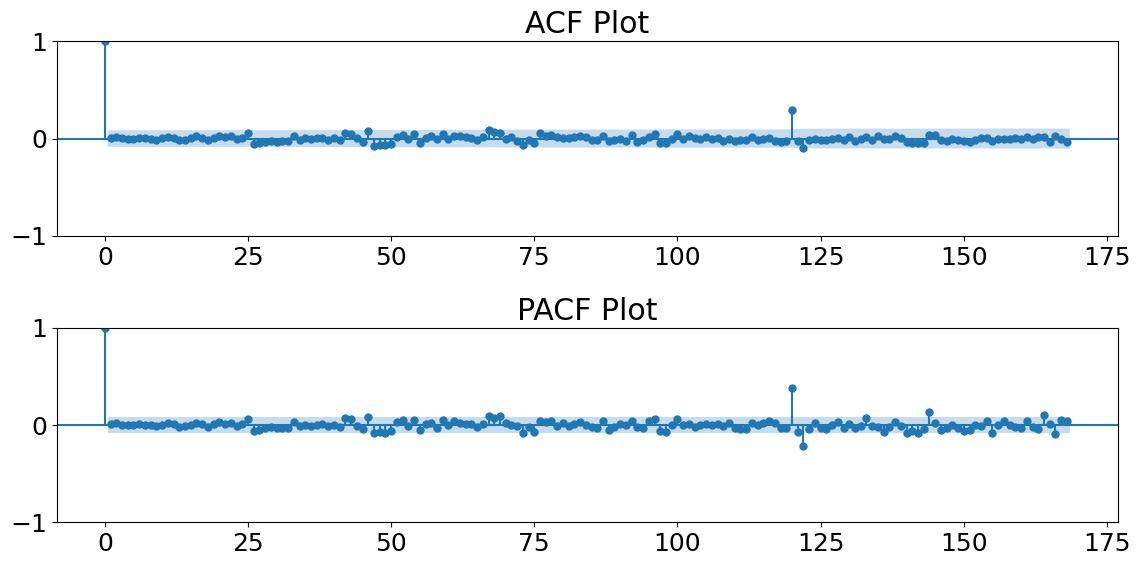

In [185]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(m_sarimax_24_0.resid, lags=168   , ax=plt.gca(), title='ACF Plot')
plt.subplot(2, 1, 2)
plot_pacf(m_sarimax_24_0.resid, lags=168, ax=plt.gca(), title='PACF Plot')
plt.tight_layout()
plt.show()

## Comparing SARIMA and SARIMAX for Training

In [186]:
mae_sarimax = np.mean(np.abs(endog_april['Count']-m_sarimax_24_0.fittedvalues))
# Print the MAE
print("Mean Absolute Error (MAE sarimax):", mae_sarimax)

mae_sarima = np.mean(np.abs(endog_april['Count']-results_0.fittedvalues))
# Print the MAE
print("Mean Absolute Error (MAE sarima):", mae_sarima)

Mean Absolute Error (MAE sarimax): 133.09875890037344
Mean Absolute Error (MAE sarima): 129.92367360581622


In [283]:
endog_april['Count']

0       12
1        7
2        7
3       14
4       28
      ... 
523    116
524    135
525     90
526     87
527     49
Name: Count, Length: 528, dtype: int64

In [320]:
np.mean(np.abs(endog_april['Count']-m_sarimax_24_0.fittedvalues))

267.82522406756203

In [321]:
np.mean(np.abs(endog_april.values-m_sarimax_24_0.fittedvalues.values))

276.9407644074813

In [316]:
# Creating a Series with integers from 0 to 9
series1 = pd.Series([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Creating a Series with random floating-point numbers
import random
random_numbers = [random.uniform(0, 1) for _ in range(10)]
series2 = pd.Series(random_numbers)

In [318]:
np.mean(np.abs(series1 - series2))

4.061176805330798

In [319]:
np.mean(np.abs(series1.values - series2.values))

4.061176805330798

## Comparing SARIMA and SARIMAX for Testing

In [299]:
# SARIMAX
# Forecast 24 hours into the future
forecast = m_sarimax_24_0.get_forecast(steps=forecast_steps, exog=regressors[528:])

# Get the forecasted values and confidence intervals
forecasted_values_sarimax = forecast.predicted_mean
confidence_intervals_sarimax = forecast.conf_int()


# SARIMA
# Forecast 24 hours into the future
forecast_sarima = results_0.get_forecast(steps=forecast_steps)

# Get the forecasted values and confidence intervals
forecasted_values_sarima = forecast_sarima.predicted_mean
confidence_intervals_sarima = forecast_sarima.conf_int()


mae_sarimax = np.mean(np.abs(df_may_south_manhattan_week['Count'][:forecast_steps].values-forecasted_values_sarimax[:forecast_steps].values))
# Print the MAE
print("Mean Absolute Error (MAE sarimax):", mae_sarimax)

# Calculate MAE
mae_sarima = np.mean(np.abs(df_may_south_manhattan_week['Count'][:forecast_steps].values-forecasted_values_sarima[:forecast_steps].values))
# Print the MAE
print("Mean Absolute Error (MAE sarima):", mae_sarima)

Mean Absolute Error (MAE sarimax): 169.08256248313742
Mean Absolute Error (MAE sarima): 208.16659588139294


In [188]:
print(f"percentage of error for sarima is {mae_sarima/endog_may['Count'][:48].sum()}")
print(f"percentage of error for sarimax is {mae_sarimax/endog_may['Count'][:48].sum()}")

percentage of error for sarima is 0.011342374319260771
percentage of error for sarimax is 0.005955659700957011


In [189]:
endog_may['Count'][:48].sum()

18353

# Predicting North Manhattan

## data preparation

In [190]:
# loading april data
df_april_north_manhattan_week = pd.read_csv(r"C:\Users\Max_G\OneDrive\IUBH\5_Semester\Model_Engeneering\Public_Transport_Forecasting\data\interim\Clustered Data\df_0_month_4_weekday.csv", index_col=[0])
df_april_north_manhattan_week.Date = pd.to_datetime(df_april_north_manhattan_week['Date'])
df_april_north_manhattan_week.index = pd.to_datetime(df_april_north_manhattan_week.index)

# loading may data
df_may_north_manhattan_week = pd.read_csv(r"C:\Users\Max_G\OneDrive\IUBH\5_Semester\Model_Engeneering\Public_Transport_Forecasting\data\interim\Clustered Data\df_0_month_5_weekday.csv", index_col=[0])
df_may_north_manhattan_week.Date = pd.to_datetime(df_may_north_manhattan_week['Date'])
df_may_north_manhattan_week.index = pd.to_datetime(df_may_north_manhattan_week.index)

In [191]:
df_april_north_manhattan_week.Count.sum()

205229

In [192]:
# for training
endog_april = df_april_north_manhattan_week.reset_index()
endog_april = endog_april.drop(columns=['index', 'Hour', 'Weekday', 'Date'])

# for testing
endog_may = df_may_north_manhattan_week.reset_index()
endog_may = endog_may .drop(columns=['index', 'Hour', 'Weekday', 'Date'])

## Creating a SARIMA Model

                                      SARIMAX Results                                       
Dep. Variable:                                Count   No. Observations:                  528
Model:             SARIMAX(0, 1, 6)x(1, 1, [1], 24)   Log Likelihood               -2883.148
Date:                              Tue, 19 Sep 2023   AIC                           5784.297
Time:                                      10:49:33   BIC                           5822.282
Sample:                                           0   HQIC                          5799.199
                                              - 528                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0516      0.038     -1.363      0.173      -0.126       0.023
ma.L2         -0.14

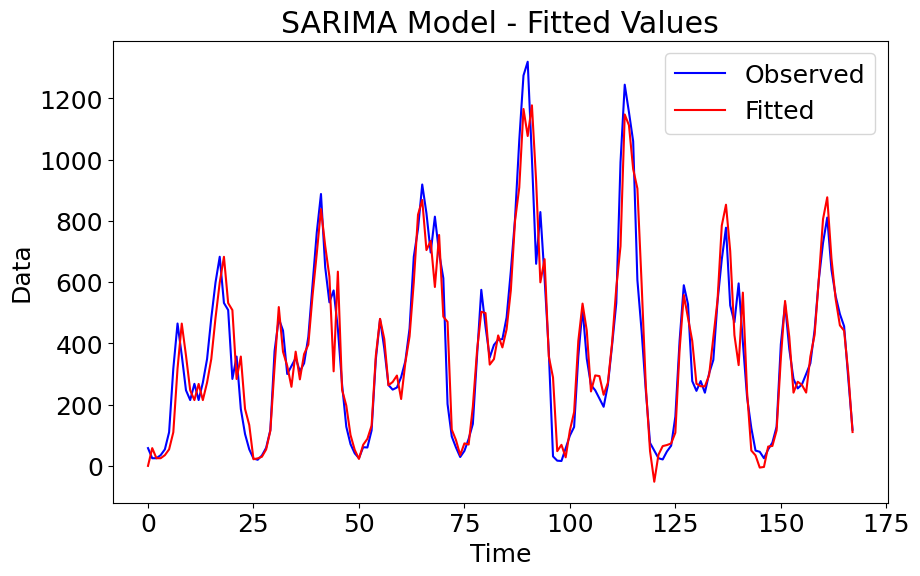

C:\Users\Max_G\AppData\Local\Temp\ipykernel_22092\3214659965.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aic = df_aic.append(new_row_data, ignore_index=True)


In [193]:
order = (0, 1, 6) 
seasonal_order=(1, 1, 1, 24)

time = np.arange(len(endog_april))

# Fit the SARIMA model with harmonic regression (exogenous variables)
model_1 = SARIMAX(endog_april, order=order, seasonal_order=seasonal_order)
results_1 = model_1.fit()

# Print the model summary
print(results_1.summary())

# Plot the observed data and the fitted values
plt.figure(figsize=(10, 6))
plt.plot(time[0:168], df_april_north_manhattan_week['Count'][0:168], label='Observed', color='blue')
plt.plot(time[0:168], results_1.fittedvalues[0:168], label='Fitted', color='red')
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('SARIMA Model - Fitted Values')
plt.legend()
plt.show()



new_row_data = {
    'location': 'North_Manhattan',
    'type': 'Sarima',
    'AIC': results_1.aic
}

# Create a DataFrame with a single row
df_aic = df_aic.append(new_row_data, ignore_index=True)

c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


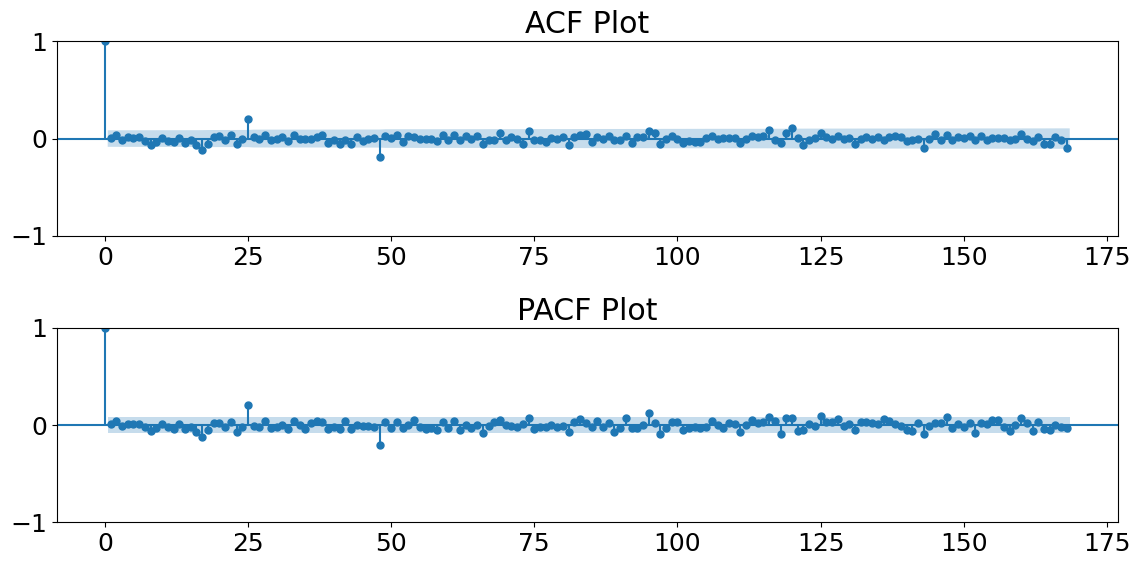

In [194]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(results_1.resid, lags=168   , ax=plt.gca(), title='ACF Plot')
plt.subplot(2, 1, 2)
plot_pacf(results_1.resid, lags=168, ax=plt.gca(), title='PACF Plot')
plt.tight_layout()
plt.show()

## Sarimax

### Harmonic Regression Preparation

In [195]:
# %% generate periodogram
freq, Pxx_spec = signal.periodogram( \
   df_april_north_manhattan_week['Count'].values, scaling='spectrum')

In [196]:
maxPsd, freqMax_week, periodMax = getMaxPeriodogram(freq, Pxx_spec, 6)

In [197]:
1/freqMax_week

array([ 24.        ,  12.        , 105.6       , 528.        ,
        31.05882353,   4.8       ])

In [198]:
# %% set font size for plots
plt.rcParams.update({'font.size': 18})

forecast_steps = 48

# (1 day = 24 hours, 1 week = 168 hours)
period01, period02, period03, period04, period05, period06= list(1/freqMax_week)

# extract the number hourly samples
T=len(df_april_south_manhattan_week)
T_predict = T+forecast_steps
time=np.arange(1,T_predict+1)

# create regressors 
omega01=2*np.pi/period01
s1=np.cos(omega01*time)
c1=np.sin(omega01*time)

# create regressors 
omega02=2*np.pi/period02
s2=np.cos(omega02*time)
c2=np.sin(omega02*time)

# create regressors 
omega03=2*np.pi/period03
s3=np.cos(omega03*time)
c3=np.sin(omega03*time)

# create regressors 
omega04=2*np.pi/period04
s4=np.cos(omega04*time)
c4=np.sin(omega04*time)

# create regressors 
omega05=2*np.pi/period05
s5=np.cos(omega05*time)
c5=np.sin(omega05*time)

# create regressors 
omega06=2*np.pi/period06
s6=np.cos(omega06*time)
c6=np.sin(omega06*time)



# %% stack regressors and add intercept
regressors = np.column_stack((s1,c1,s2,c2,s3,c3,s4,c4,s5,c5,s6,c6))
regressors_one = sm.add_constant(regressors)

exog_var = regressors[:528]

# %% create and fit the regression model
model = sm.OLS(df_april_north_manhattan_week['Count'], regressors_one[:528])
results_harmonic = model.fit()

In [199]:
results_harmonic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     178.2
Date:                Tue, 19 Sep 2023   Prob (F-statistic):          1.58e-174
Time:                        10:49:33   Log-Likelihood:                -3328.2
No. Observations:                 528   AIC:                             6682.
Df Residuals:                     515   BIC:                             6738.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        388.6913      5.826     66.718      0.000     377.246     400.137
x1           -71.4645      8.239     -8.674      0.000     -87.651     -55.278
x2          -289.6306      8.239    -35.153      0.000    -305.817    -273.444
x3          -142.2759      8.239    -17.268      0.000    -158.462    -126.090
x4          -131.3215      8.239    -15.939      0.000    -147.508    -115.135
x5            56.3727      8.239      6.842      0.000      40.186      72.559
x6           -67.1468      8.239     -8.150      0.000     -83.333     -50.960
x7            65.1086      8.239      7.902      0.000      48.922      81.295
x8             4.0142      8.239      0.487      0.626     -12.172      20.201
x9            42.3831      8.239      5.144      0.000      26.197      58.569
x10          -42.2982      8.239     -5.134      0.000     -58.485     -26.112
x11          -34.6620      8.239     -4.207      0.000     -50.848     -18.476
x12          -44.0846      8.239     -5.351      0.000     -60.271     -27.898
==============================================================================
Omnibus:                      101.160   Durbin-Watson:                   0.362
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              242.372
Skew:                           0.984   Prob(JB):                     2.34e-53
Kurtosis:                       5.672   Cond. No.                         1.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


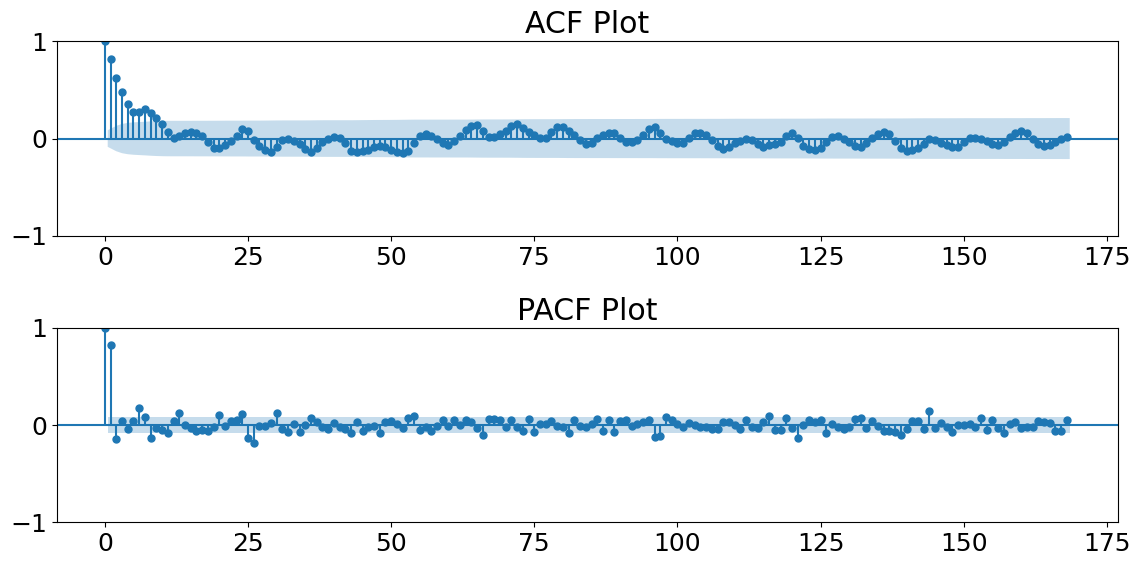

In [200]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(results_harmonic.resid, lags=168   , ax=plt.gca(), title='ACF Plot')
plt.subplot(2, 1, 2)
plot_pacf(results_harmonic.resid, lags=168, ax=plt.gca(), title='PACF Plot')
plt.tight_layout()
plt.show()

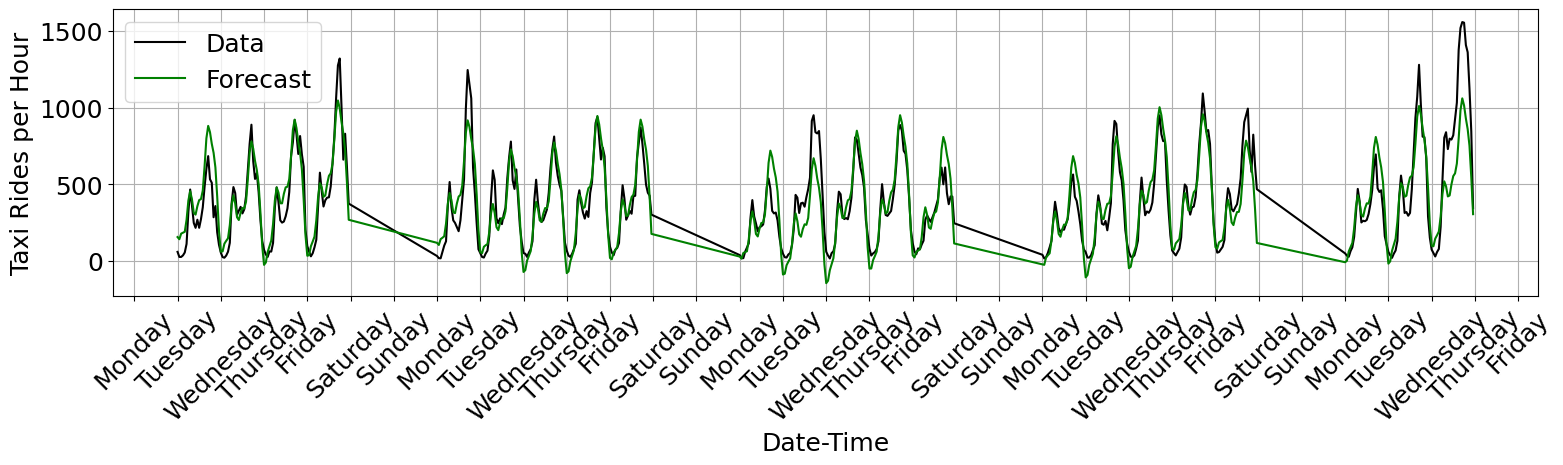

In [201]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot(df_april_north_manhattan_week.index, df_april_north_manhattan_week['Count'], color='k', label='Data')

# Fitted values
plt.plot(df_april_north_manhattan_week.index, results_harmonic.fittedvalues, color='green', label='Forecast')

# Add labels, ticks, and legend
plt.gca().set(xlabel='Date-Time', ylabel='Taxi Rides per Hour')

# Set ticks every 24 hours
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Set tick format to display the weekday name
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%A'))

plt.xticks(rotation=45)  # Rotate the tick labels for better readability

plt.legend()
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

### Combining Harmonic Regression with ARMA

In [202]:
arma_model = sm.tsa.ARIMA(results_harmonic.resid, order=(24, 0, 0))
arma_result = arma_model.fit()

c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


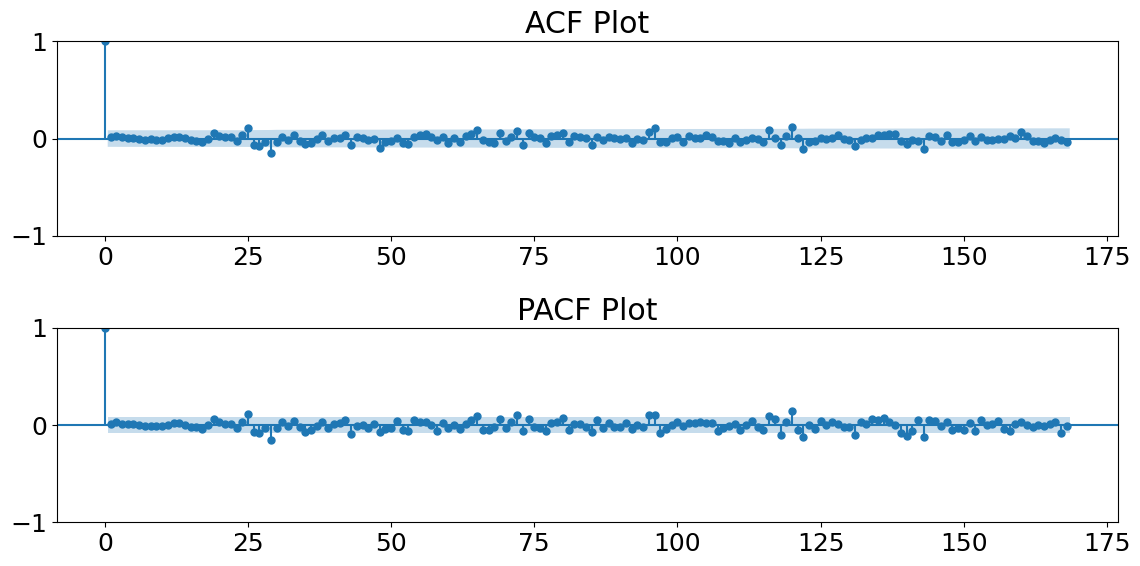

In [203]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(arma_result.resid, lags=168   , ax=plt.gca(), title='ACF Plot')
plt.subplot(2, 1, 2)
plot_pacf(arma_result.resid, lags=168, ax=plt.gca(), title='PACF Plot')
plt.tight_layout()
plt.show()

### putting it all together SARIMAX

In [204]:
order = (24, 0, 0)
seasonal_order = (0, 0, 0, 0)
model = SARIMAX(endog=endog_april['Count'], exog=exog_var, \
    trend='c', order=order, \
    seasonal_order=seasonal_order, \
    enforce_stationarity=True, \
    enforce_invertibility=True)
m_sarimax_24_1 = model.fit()


new_row_data = {
    'location': 'North_Manhattan',
    'type': 'Sarimax',
    'AIC': m_sarimax_24_1.aic
}

# Create a DataFrame with a single row
df_aic = df_aic.append(new_row_data, ignore_index=True)

c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Max_G\AppData\Local\Temp\ipykernel_22092\1809547575.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aic = df_aic.append(new_row_data, ignore_index=True)


In [205]:
m_sarimax_24_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Count   No. Observations:                  528
Model:              SARIMAX(24, 0, 0)   Log Likelihood               -2997.438
Date:                Tue, 19 Sep 2023   AIC                           6070.876
Time:                        10:49:57   BIC                           6233.102
Sample:                             0   HQIC                          6134.384
                                - 528                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     66.8400     23.762      2.813      0.005      20.267     113.414
x1           -70.8245     16.269     -4.353      0.000    -102.712     -38.937
x2          -289.4011     20.538    -14.091      0.000    -329.654    -249.148
x3          -141.9913     12.882    -11.022      0.000    -167.240    -116.742
x4          -131.3765     11.630    -11.297      0.000    -154.170    -108.583
x5            55.9739     24.923      2.246      0.025       7.125     104.823
x6           -66.8251     25.491     -2.622      0.009    -116.786     -16.864
x7            64.8927     29.227      2.220      0.026       7.608     122.177
x8             4.1065     30.876      0.133      0.894     -56.410      64.623
x9            42.4302     30.910      1.373      0.170     -18.153     103.013
x10          -42.5871     28.542     -1.492      0.136     -98.528      13.354
x11          -35.0372      4.438     -7.896      0.000     -43.735     -26.340
x12          -43.8885      4.993     -8.789      0.000     -53.675     -34.102
ar.L1          0.9061      0.043     21.196      0.000       0.822       0.990
ar.L2         -0.1343      0.066     -2.046      0.041      -0.263      -0.006
ar.L3          0.0682      0.060      1.147      0.252      -0.048       0.185
ar.L4         -0.0406      0.062     -0.659      0.510      -0.161       0.080
ar.L5         -0.0806      0.070     -1.154      0.249      -0.218       0.056
ar.L6          0.0283      0.074      0.381      0.703      -0.117       0.174
ar.L7          0.1770      0.080      2.204      0.027       0.020       0.334
ar.L8         -0.0850      0.083     -1.029      0.303      -0.247       0.077
ar.L9          0.0132      0.073      0.180      0.857      -0.130       0.157
ar.L10         0.0242      0.071      0.342      0.732      -0.115       0.163
ar.L11        -0.1027      0.077     -1.338      0.181      -0.253       0.048
ar.L12        -0.0577      0.074     -0.778      0.437      -0.203       0.088
ar.L13         0.1045      0.076      1.380      0.168      -0.044       0.253
ar.L14         0.0065      0.075      0.087      0.930      -0.140       0.153
ar.L15         0.0241      0.076      0.320      0.749      -0.124       0.172
ar.L16        -0.0156      0.073     -0.213      0.832      -0.160       0.128
ar.L17        -0.0294      0.072     -0.409      0.682      -0.170       0.111
ar.L18        -0.0196      0.073     -0.269      0.788      -0.162       0.123
ar.L19        -0.1017      0.069     -1.484      0.138      -0.236       0.033
ar.L20         0.1054      0.059      1.792      0.073      -0.010       0.221
ar.L21        -0.0432      0.058     -0.747      0.455      -0.156       0.070
ar.L22         0.0155      0.056      0.276      0.782      -0.094       0.125
ar.L23        -0.0569      0.058     -0.986      0.324      -0.170       0.056
ar.L24         0.1220      0.046      2.637      0.008       0.031       0.213
sigma2      4927.5315    242.134     20.350      0.000    4452.958    5402.105
==

c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


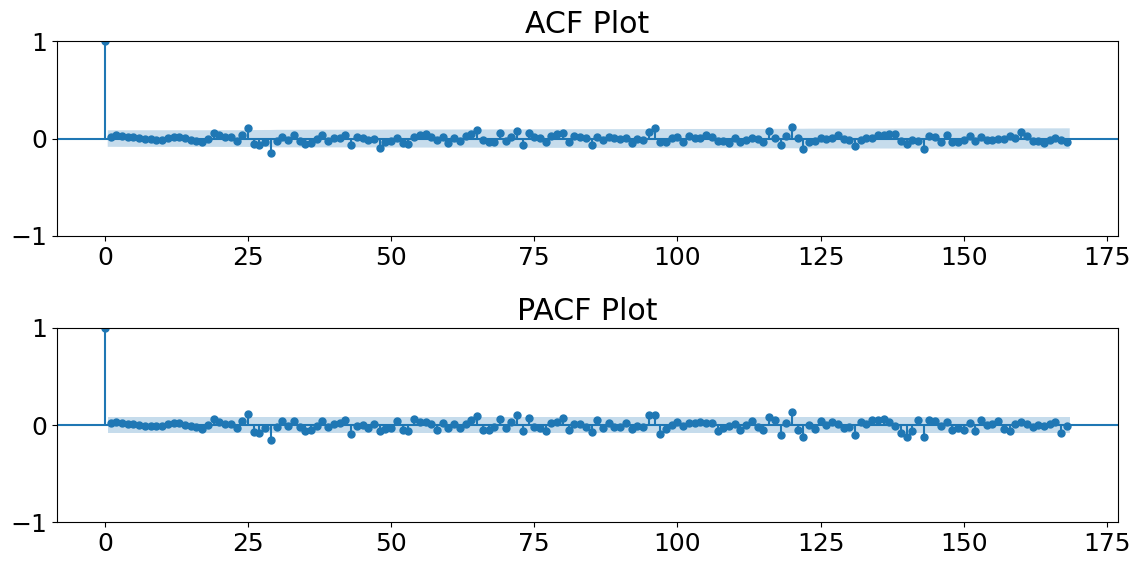

In [206]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(m_sarimax_24_1.resid, lags=168   , ax=plt.gca(), title='ACF Plot')
plt.subplot(2, 1, 2)
plot_pacf(m_sarimax_24_1.resid, lags=168, ax=plt.gca(), title='PACF Plot')
plt.tight_layout()
plt.show()

## Comparing SARIMA and SARIMAX for Training

In [207]:
# I have created the may data and reworked it above as data_0_predict
mae_sarimax = np.mean(np.abs(endog_may['Count']-m_sarimax_24_1.fittedvalues))
# Print the MAE
print("Mean Absolute Error (MAE sarimax):", mae_sarimax)

mae_sarima = np.mean(np.abs(endog_may['Count']-results_1.fittedvalues))
# Print the MAE
print("Mean Absolute Error (MAE sarima):", mae_sarima)

Mean Absolute Error (MAE sarimax): 162.38035679195016
Mean Absolute Error (MAE sarima): 160.82499916917314


## Comparing SARIMA and SARIMAX Testing

In [208]:
forecast = m_sarimax_24_1.get_forecast(steps=forecast_steps, exog=regressors[528:])

In [209]:
# SARIMAX
# Forecast 24 hours into the future
forecast = m_sarimax_24_1.get_forecast(steps=forecast_steps, exog=regressors[528:])

# Get the forecasted values and confidence intervals
forecasted_values_sarimax = forecast.predicted_mean
confidence_intervals_sarimax = forecast.conf_int()


# SARIMA
# Forecast 24 hours into the future
forecast_sarima = results_1.get_forecast(steps=forecast_steps)

# Get the forecasted values and confidence intervals
forecasted_values_sarima = forecast_sarima.predicted_mean
confidence_intervals_sarima = forecast_sarima.conf_int()


mae_sarimax = np.mean(np.abs(df_may_north_manhattan_week['Count'][:forecast_steps].values-forecasted_values_sarimax[:forecast_steps].values))
# Print the MAE
print("Mean Absolute Error (MAE sarimax):", mae_sarimax)

# Calculate MAE
mae_sarima = np.mean(np.abs(df_may_north_manhattan_week['Count'][:forecast_steps].values-forecasted_values_sarima[:forecast_steps].values))
# Print the MAE
print("Mean Absolute Error (MAE sarima):", mae_sarima)

Mean Absolute Error (MAE sarimax): 119.39300165855165
Mean Absolute Error (MAE sarima): 343.60258706975134


In [210]:
print(f"percentage of error for sarima is {mae_sarima/endog_may['Count'][:48].sum()}")
print(f"percentage of error for sarimax is {mae_sarimax/endog_may['Count'][:48].sum()}")

percentage of error for sarima is 0.015767372754669207
percentage of error for sarimax is 0.005478753747180234


In [211]:
endog_may['Count'][:48].sum()

21792

# Predicting Brooklyn

## data preparation

In [212]:
# loading april data
df_april_brooklyn_week = pd.read_csv(r"C:\Users\Max_G\OneDrive\IUBH\5_Semester\Model_Engeneering\Public_Transport_Forecasting\data\interim\Clustered Data\df_5_month_4_weekday.csv", index_col=[0])
df_april_brooklyn_week.Date = pd.to_datetime(df_april_brooklyn_week['Date'])
df_april_brooklyn_week.index = pd.to_datetime(df_april_brooklyn_week.index)

# loading may data
df_may_brooklyn_week = pd.read_csv(r"C:\Users\Max_G\OneDrive\IUBH\5_Semester\Model_Engeneering\Public_Transport_Forecasting\data\interim\Clustered Data\df_5_month_5_weekday.csv", index_col=[0])
df_may_brooklyn_week.Date = pd.to_datetime(df_may_brooklyn_week['Date'])
df_may_brooklyn_week.index = pd.to_datetime(df_may_brooklyn_week.index)

In [213]:
df_april_brooklyn_week.Count.sum()

29411

In [214]:
# for training
endog_april = df_april_brooklyn_week.reset_index()
endog_april = endog_april.drop(columns=['index', 'Hour', 'Weekday', 'Date'])

# for testing
endog_may = df_may_brooklyn_week.reset_index()
endog_may = endog_may .drop(columns=['index', 'Hour', 'Weekday', 'Date'])

## Creating a SARIMA Model

                                      SARIMAX Results                                       
Dep. Variable:                                Count   No. Observations:                  528
Model:             SARIMAX(0, 1, 6)x(1, 1, [1], 24)   Log Likelihood               -2037.848
Date:                              Tue, 19 Sep 2023   AIC                           4093.695
Time:                                      10:50:04   BIC                           4131.680
Sample:                                           0   HQIC                          4108.597
                                              - 528                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3934      0.043     -9.185      0.000      -0.477      -0.309
ma.L2         -0.13

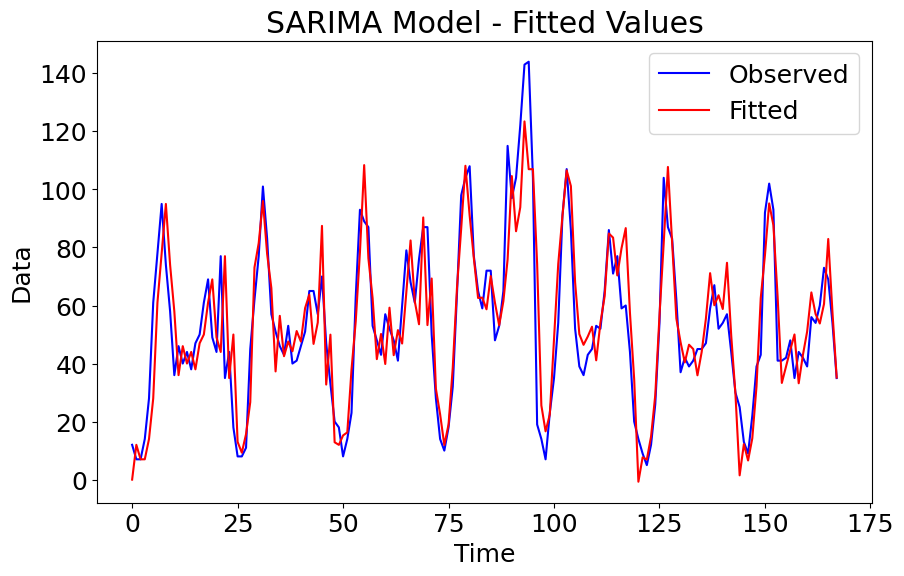

C:\Users\Max_G\AppData\Local\Temp\ipykernel_22092\2076107383.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aic = df_aic.append(new_row_data, ignore_index=True)


In [215]:
order = (0, 1, 6) 
seasonal_order=(1, 1, 1, 24)

time = np.arange(len(endog_april))

# Fit the SARIMA model with harmonic regression (exogenous variables)
model_2 = SARIMAX(endog=endog_april, order=order, seasonal_order=seasonal_order)
results_2 = model_2.fit()

# Print the model summary
print(results_2.summary())

# Plot the observed data and the fitted values
plt.figure(figsize=(10, 6))
plt.plot(time[0:168], df_april_brooklyn_week['Count'][0:168], label='Observed', color='blue')
plt.plot(time[0:168], results_2.fittedvalues[0:168], label='Fitted', color='red')
plt.xlabel('Time')
plt.ylabel('Data')
plt.title('SARIMA Model - Fitted Values')
plt.legend()
plt.show()



new_row_data = {
    'location': 'Brooklyn',
    'type': 'Sarimax',
    'AIC': results_2.aic
}

# Create a DataFrame with a single row
df_aic = df_aic.append(new_row_data, ignore_index=True)

c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


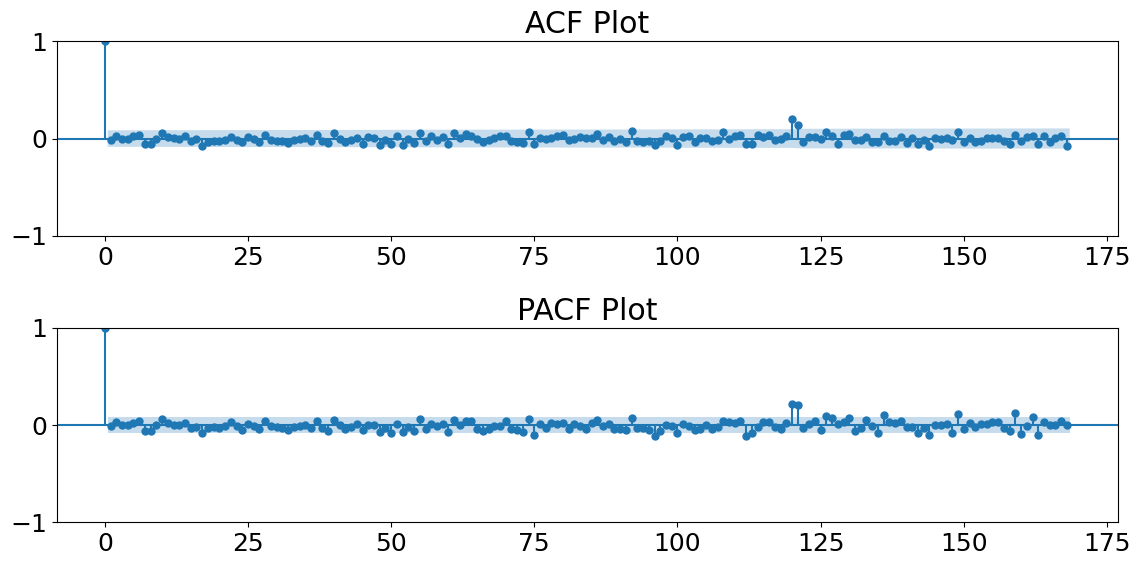

In [216]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(results_2.resid, lags=168   , ax=plt.gca(), title='ACF Plot')
plt.subplot(2, 1, 2)
plot_pacf(results_2.resid, lags=168, ax=plt.gca(), title='PACF Plot')
plt.tight_layout()
plt.show()

## Sarimax

### Harmonic Regression Preparation

In [217]:
# %% generate periodogram
freq, Pxx_spec = signal.periodogram( \
   df_april_brooklyn_week['Count'].values, scaling='spectrum')
   
maxPsd, freqMax_week, periodMax = getMaxPeriodogram(freq ,Pxx_spec, 5)

1/freqMax_week

array([ 12.        ,   8.        ,  24.        , 105.6       ,
        58.66666667])

In [218]:
# %% set font size for plots
plt.rcParams.update({'font.size': 18})

forecast_steps = 48

# (1 day = 24 hours, 1 week = 168 hours)
period01, period02, period03, period04, period05= list(1/freqMax_week)

# extract the number hourly samples
T=len(df_april_south_manhattan_week)
T_predict = T+forecast_steps
time=np.arange(1,T_predict+1)

# create regressors 
omega01=2*np.pi/period01
s1=np.cos(omega01*time)
c1=np.sin(omega01*time)

# create regressors 
omega02=2*np.pi/period02
s2=np.cos(omega02*time)
c2=np.sin(omega02*time)

# create regressors 
omega03=2*np.pi/period03
s3=np.cos(omega03*time)
c3=np.sin(omega03*time)

# create regressors 
omega04=2*np.pi/period04
s4=np.cos(omega04*time)
c4=np.sin(omega04*time)

# create regressors 
omega05=2*np.pi/period05
s5=np.cos(omega05*time)
c5=np.sin(omega05*time)





# %% stack regressors and add intercept
regressors = np.column_stack((s1,c1,s2,c2,s3,c3,s4,c4,s5,c5))
regressors_one = sm.add_constant(regressors)

exog_var = regressors[:528]

# %% create and fit the regression model
model = sm.OLS(df_april_brooklyn_week['Count'], regressors_one[:528])
results_harmonic = model.fit()

In [219]:
results_harmonic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     110.8
Date:                Tue, 19 Sep 2023   Prob (F-statistic):          1.07e-121
Time:                        10:50:05   Log-Likelihood:                -2224.0
No. Observations:                 528   AIC:                             4470.
Df Residuals:                     517   BIC:                             4517.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         55.7027      0.718     77.539      0.000      54.291      57.114
x1            -5.3014      1.016     -5.218      0.000      -7.297      -3.306
x2           -26.9344      1.016    -26.512      0.000     -28.930     -24.939
x3            10.3448      1.016     10.182      0.000       8.349      12.341
x4            -9.4351      1.016     -9.287      0.000     -11.431      -7.439
x5            -5.8718      1.016     -5.780      0.000      -7.868      -3.876
x6            -8.2243      1.016     -8.095      0.000     -10.220      -6.228
x7             6.8529      1.016      6.745      0.000       4.857       8.849
x8            -2.2989      1.016     -2.263      0.024      -4.295      -0.303
x9            -4.2240      1.016     -4.158      0.000      -6.220      -2.228
x10           -4.7152      1.016     -4.641      0.000      -6.711      -2.719
==============================================================================
Omnibus:                      152.765   Durbin-Watson:                   0.865
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              669.213
Skew:                           1.230   Prob(JB):                    4.81e-146
Kurtosis:                       7.937   Cond. No.                         1.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


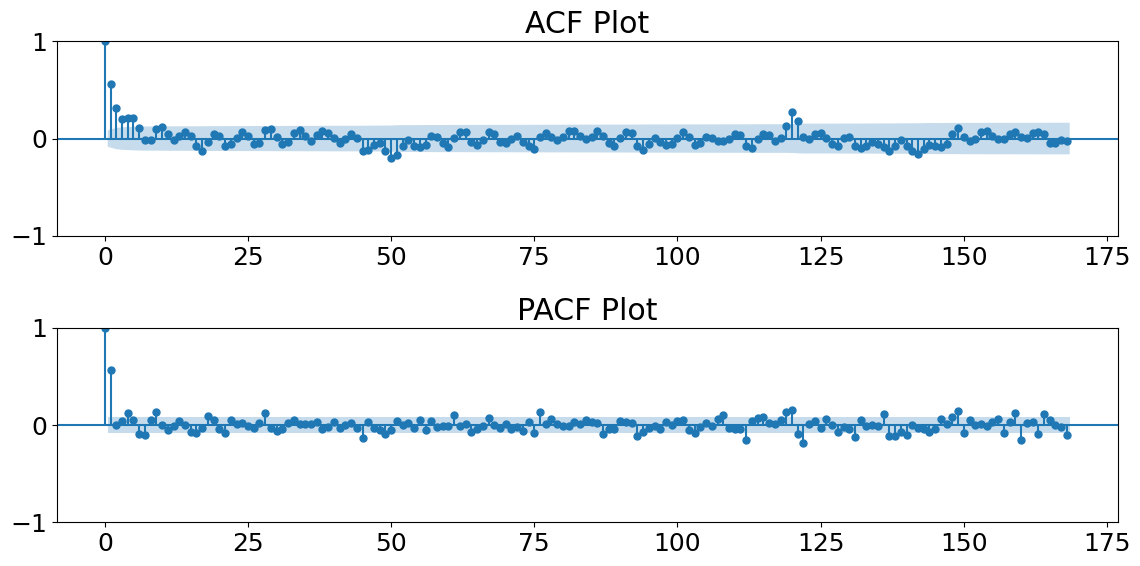

In [220]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(results_harmonic.resid, lags=168   , ax=plt.gca(), title='ACF Plot')
plt.subplot(2, 1, 2)
plot_pacf(results_harmonic.resid, lags=168, ax=plt.gca(), title='PACF Plot')
plt.tight_layout()
plt.show()

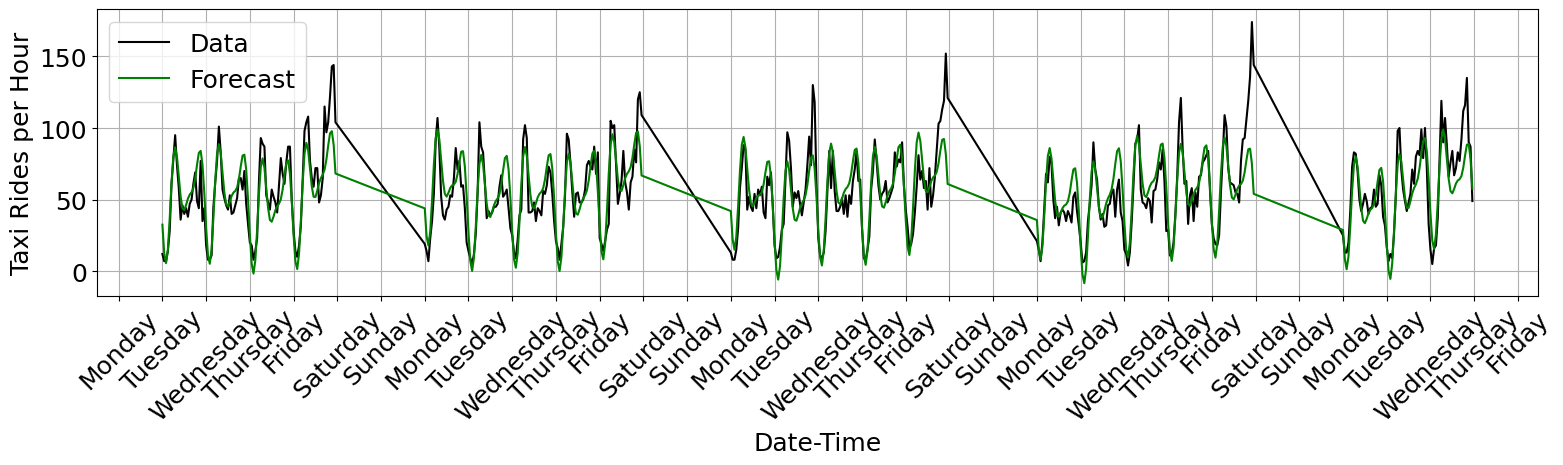

In [221]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot(df_april_brooklyn_week.index, df_april_brooklyn_week['Count'], color='k', label='Data')

# Fitted values
plt.plot(df_april_brooklyn_week.index, results_harmonic.fittedvalues, color='green', label='Forecast')

# Add labels, ticks, and legend
plt.gca().set(xlabel='Date-Time', ylabel='Taxi Rides per Hour')

# Set ticks every 24 hours
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Set tick format to display the weekday name
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%A'))

plt.xticks(rotation=45)  # Rotate the tick labels for better readability

plt.legend()
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

### Combining Harmonic Regression with ARMA

In [222]:
arma_model = sm.tsa.ARIMA(results_harmonic.resid, order=(24, 0, 0))
arma_result = arma_model.fit()

c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


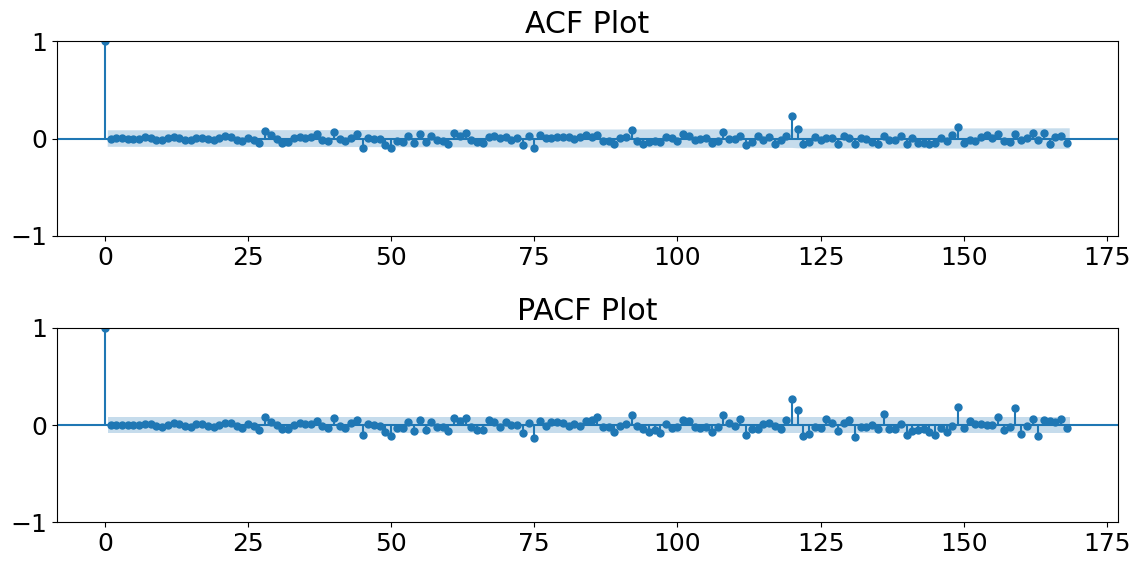

In [223]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(arma_result.resid, lags=168   , ax=plt.gca(), title='ACF Plot')
plt.subplot(2, 1, 2)
plot_pacf(arma_result.resid, lags=168, ax=plt.gca(), title='PACF Plot')
plt.tight_layout()
plt.show()

### putting it all together SARIMAX

In [224]:
order = (24, 0, 0)
seasonal_order = (0, 0, 0, 0)
model = SARIMAX(endog=endog_april['Count'], exog=exog_var, \
    trend='c', order=order, \
    seasonal_order=seasonal_order, \
    enforce_stationarity=True, \
    enforce_invertibility=True)
m_sarimax_24_2 = model.fit()



new_row_data = {
    'location': 'Brooklyn',
    'type': 'Sarimax',
    'AIC': m_sarimax_24_2.aic
}

# Create a DataFrame with a single row
df_aic = df_aic.append(new_row_data, ignore_index=True)



file_path = r"C:\Users\Max_G\OneDrive\IUBH\5_Semester\Model_Engeneering\Public_Transport_Forecasting\data\interim\df_aic_april_per_cluster.csv"

# Save the DataFrame to a CSV file in the specified folder
df_aic.to_csv(file_path, index=False)


c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Max_G\AppData\Local\Temp\ipykernel_22092\2123571525.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_aic = df_aic.append(new_row_data, ignore_index=True)


In [225]:
df_aic

,location,type,AIC
0,South_Manhattan,Sarima,5933.267117
1,South_Manhattan,Sarimax,6207.401402
2,North_Manhattan,Sarima,5784.296964
3,North_Manhattan,Sarimax,6070.876224
4,Brooklyn,Sarimax,4093.695102
5,Brooklyn,Sarimax,4264.423947


In [226]:
m_sarimax_24_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Count   No. Observations:                  528
Model:              SARIMAX(24, 0, 0)   Log Likelihood               -2096.212
Date:                Tue, 19 Sep 2023   AIC                           4264.424
Time:                        10:50:24   BIC                           4418.111
Sample:                             0   HQIC                          4324.589
                                - 528                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     21.0842      5.747      3.669      0.000       9.820      32.348
x1            -5.3322      1.901     -2.805      0.005      -9.059      -1.606
x2           -26.9429      1.887    -14.279      0.000     -30.641     -23.245
x3            10.4171      1.007     10.343      0.000       8.443      12.391
x4            -9.4062      0.969     -9.711      0.000     -11.305      -7.508
x5            -5.8737      1.859     -3.160      0.002      -9.517      -2.230
x6            -8.2111      2.451     -3.350      0.001     -13.015      -3.407
x7             6.8265      2.277      2.998      0.003       2.363      11.290
x8            -2.2997      2.472     -0.930      0.352      -7.145       2.545
x9            -4.2489      2.374     -1.790      0.073      -8.902       0.404
x10           -4.7193      2.568     -1.838      0.066      -9.752       0.314
ar.L1          0.5403      0.043     12.435      0.000       0.455       0.625
ar.L2          0.0519      0.054      0.957      0.339      -0.054       0.158
ar.L3         -0.0195      0.064     -0.306      0.759      -0.144       0.105
ar.L4          0.0352      0.060      0.587      0.557      -0.082       0.153
ar.L5          0.0816      0.064      1.285      0.199      -0.043       0.206
ar.L6         -0.0071      0.058     -0.124      0.902      -0.120       0.106
ar.L7         -0.1065      0.053     -1.997      0.046      -0.211      -0.002
ar.L8         -0.0355      0.057     -0.621      0.534      -0.147       0.076
ar.L9          0.0962      0.053      1.800      0.072      -0.009       0.201
ar.L10         0.0345      0.055      0.632      0.528      -0.073       0.142
ar.L11        -0.0157      0.052     -0.305      0.760      -0.117       0.085
ar.L12        -0.0167      0.059     -0.283      0.777      -0.132       0.099
ar.L13         0.0230      0.061      0.377      0.706      -0.096       0.142
ar.L14         0.0210      0.060      0.351      0.726      -0.096       0.138
ar.L15        -0.0174      0.061     -0.284      0.776      -0.137       0.103
ar.L16        -0.0567      0.057     -0.992      0.321      -0.169       0.055
ar.L17        -0.0811      0.064     -1.260      0.208      -0.207       0.045
ar.L18         0.0640      0.061      1.058      0.290      -0.055       0.183
ar.L19         0.0663      0.063      1.052      0.293      -0.057       0.190
ar.L20         0.0013      0.065      0.021      0.983      -0.125       0.128
ar.L21        -0.1006      0.060     -1.672      0.094      -0.218       0.017
ar.L22         0.0400      0.053      0.757      0.449      -0.064       0.144
ar.L23         0.0008      0.056      0.015      0.988      -0.108       0.110
ar.L24         0.0218      0.051      0.430      0.668      -0.078       0.122
sigma2       163.5225      8.383     19.506      0.000     147.091     179.954
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              

c:\Users\Max_G\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


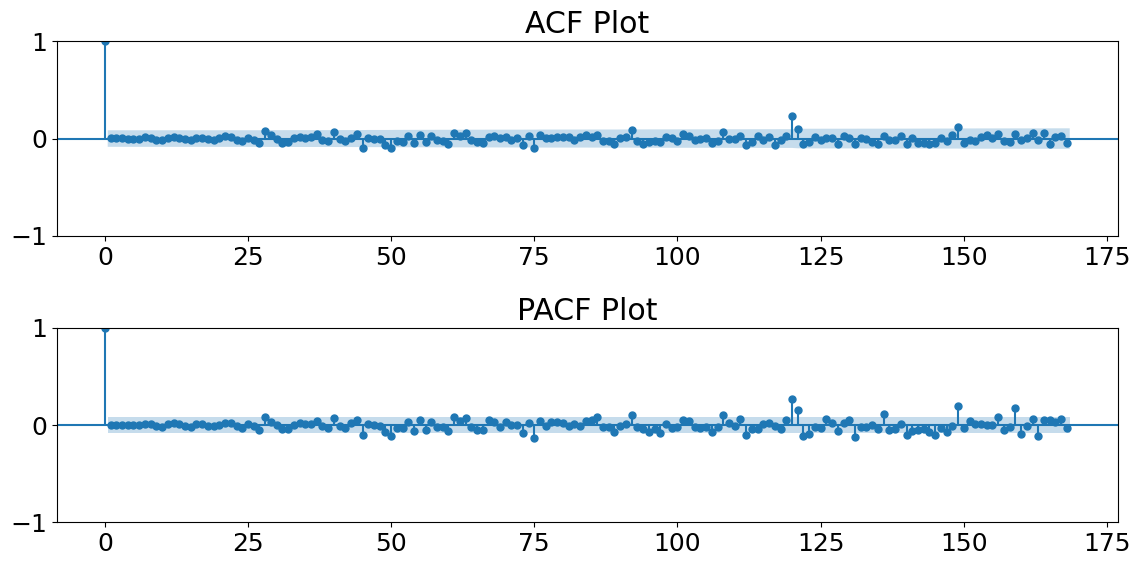

In [227]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(m_sarimax_24_2.resid, lags=168   , ax=plt.gca(), title='ACF Plot')
plt.subplot(2, 1, 2)
plot_pacf(m_sarimax_24_2.resid, lags=168, ax=plt.gca(), title='PACF Plot')
plt.tight_layout()
plt.show()

## Comparing SARIMA and SARIMAX for Training

In [228]:
# I have created the may data and reworked it above as data_0_predict
mae_sarimax = np.mean(np.abs(endog_may['Count']-m_sarimax_24_2.fittedvalues))
# Print the MAE
print("Mean Absolute Error (MAE sarimax):", mae_sarimax)

mae_sarima = np.mean(np.abs(endog_may['Count']-results_2.fittedvalues))
# Print the MAE
print("Mean Absolute Error (MAE sarima):", mae_sarima)

Mean Absolute Error (MAE sarimax): 19.165224355078415
Mean Absolute Error (MAE sarima): 19.718773304867806


## Comparing SARIMA and SARIMAX Testing

In [229]:
forecast = m_sarimax_24_2.get_forecast(steps=forecast_steps, exog=regressors[528:])

In [230]:
# SARIMAX
# Forecast 24 hours into the future
forecast = m_sarimax_24_2.get_forecast(steps=forecast_steps, exog=regressors[528:])

# Get the forecasted values and confidence intervals
forecasted_values_sarimax = forecast.predicted_mean
confidence_intervals_sarimax = forecast.conf_int()


# SARIMA
# Forecast 24 hours into the future
forecast_sarima = results_2.get_forecast(steps=forecast_steps)

# Get the forecasted values and confidence intervals
forecasted_values_sarima = forecast_sarima.predicted_mean
confidence_intervals_sarima = forecast_sarima.conf_int()


mae_sarimax = np.mean(np.abs(df_may_brooklyn_week['Count'][:forecast_steps].values-forecasted_values_sarimax[:forecast_steps].values))
# Print the MAE
print("Mean Absolute Error (MAE sarimax):", mae_sarimax)

# Calculate MAE
mae_sarima = np.mean(np.abs(df_may_brooklyn_week['Count'][:forecast_steps].values-forecasted_values_sarima[:forecast_steps].values))
# Print the MAE
print("Mean Absolute Error (MAE sarima):", mae_sarima)

Mean Absolute Error (MAE sarimax): 19.50108419610203
Mean Absolute Error (MAE sarima): 12.922635866689063


In [1]:
print(f"percentage of error for sarima is {mae_sarima/endog_may['Count'][:48].sum()/len(endog_may['Count'][:48].sum())}")
print(f"percentage of error for sarimax is {mae_sarimax/endog_may['Count'][:48].sum()/len(endog_may['Count'][:48].sum())}")

NameError: name 'mae_sarima' is not defined